## Import Thư Viện và đọc dữ liệu

In [231]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objs import Line
import math
import sklearn
import sklearn.preprocessing
import datetime as dt
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.    model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from keras.    models import Sequential
from keras.layers import Dense, GRU
from keras.layers import SimpleRNN, Bidirectional, BatchNormalization
from keras.layers import Dropout
from keras import optimizers
from xgboost import XGBRegressor

In [232]:
df = pd.read_csv('D:/Hệ hỗ trợ/data_hht.csv')

In [233]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5796 entries, 0 to 5795
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5796 non-null   object 
 1   open       5796 non-null   float64
 2   high       5796 non-null   float64
 3   low        5796 non-null   float64
 4   close      5796 non-null   float64
 5   volume     5796 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 271.8+ KB
None


## Xử lý dữ liệu

In [234]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M')


# Đặt cột 'Date' làm Datetime Index
df.set_index('timestamp', inplace=True)

# Kiểm tra lại thông tin của DataFrame
print(df.info())

# Xem các dòng đầu tiên của DataFrame
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5796 entries, 2022-12-01 07:00:00 to 2024-06-20 19:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5796 non-null   float64
 1   high    5796 non-null   float64
 2   low     5796 non-null   float64
 3   close   5796 non-null   float64
 4   volume  5796 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 271.7 KB
None
                        open     high      low    close  volume
timestamp                                                      
2022-12-01 07:00:00  140.220  140.937  140.128  140.867     453
2022-12-01 08:00:00  140.805  141.192  140.600  140.650    1408
2022-12-01 09:00:00  141.069  141.674  140.158  141.122  448532
2022-12-01 10:00:00  141.258  141.494  139.034  139.630  383921
2022-12-01 11:00:00  139.663  139.870  139.251  139.763  414684


In [235]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5796 entries, 2022-12-01 07:00:00 to 2024-06-20 19:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    5796 non-null   float64
 1   high    5796 non-null   float64
 2   low     5796 non-null   float64
 3   close   5796 non-null   float64
 4   volume  5796 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 271.7 KB
None


In [236]:
df.shape

(5796, 5)

Text(0.5, 1.0, 'Stock Price of IBM')

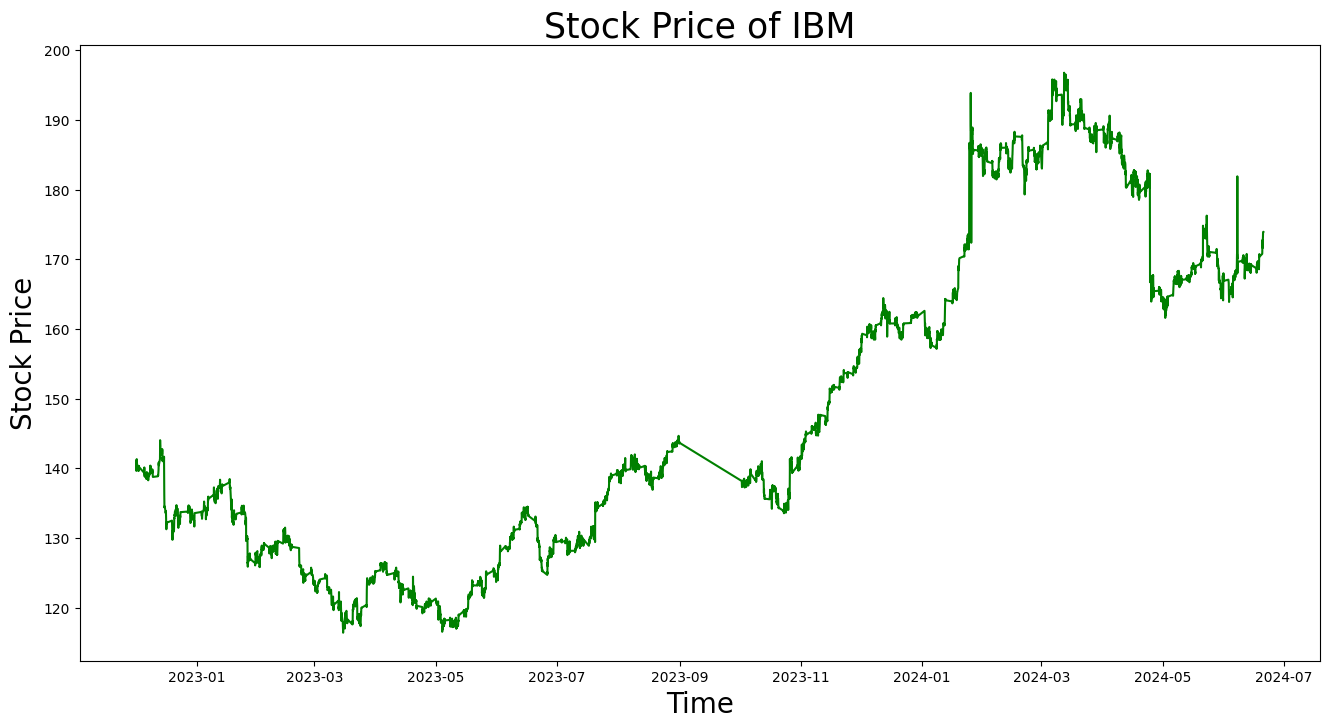

In [237]:
plt.figure(figsize=(16,8))
plt.plot(df['close'], label='close Price history',color='g')
plt.xlabel('Time',size=20)
plt.ylabel('Stock Price',size=20)
plt.title('Stock Price of IBM',size=25)

Kiểm tra dữ liệu thiếu

In [238]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [239]:
df.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [240]:
df.duplicated().sum()

211

In [241]:
df = df.drop_duplicates()

In [242]:
df.duplicated().sum()

0

In [243]:
df.shape

(5585, 5)

Loại bỏ điểm ngoại lai

In [244]:
for column in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

print("\nDataFrame sau khi xử lý các giá trị ngoại lệ bằng phương pháp IQR:")
print(df)


DataFrame sau khi xử lý các giá trị ngoại lệ bằng phương pháp IQR:
                        open     high      low    close     volume
timestamp                                                         
2022-12-01 07:00:00  140.220  140.937  140.128  140.867      453.0
2022-12-01 08:00:00  140.805  141.192  140.600  140.650     1408.0
2022-12-01 09:00:00  141.069  141.674  140.158  141.122   448532.0
2022-12-01 10:00:00  141.258  141.494  139.034  139.630   383921.0
2022-12-01 11:00:00  139.663  139.870  139.251  139.763   414684.0
...                      ...      ...      ...      ...        ...
2024-06-20 15:00:00  173.930  174.240  173.555  173.900   998008.0
2024-06-20 16:00:00  173.870  173.970  172.800  173.900  1225604.0
2024-06-20 17:00:00  173.850  173.900  173.600  173.900      523.0
2024-06-20 18:00:00  173.900  173.920  173.800  173.900   856099.0
2024-06-20 19:00:00  173.920  173.920  173.820  173.920   855126.0

[5585 rows x 5 columns]


## Thống kê dữ liệu mẫu

In [245]:
print(df.describe())

              open         high          low        close        volume
count  5585.000000  5585.000000  5585.000000  5585.000000  5.585000e+03
mean    149.922331   150.301102   149.495601   149.912088  3.299665e+05
std      23.047833    23.152454    22.942366    23.049758  3.604722e+05
min     116.414000   116.937000   116.270000   116.402000  1.000000e+00
25%     129.635000   129.913000   129.348000   129.621000  1.159000e+03
50%     141.069000   141.523000   140.642000   141.117000  2.538460e+05
75%     168.450000   168.990000   168.000000   168.420000  4.909370e+05
max     197.214000   197.818000   196.056000   196.784000  1.225604e+06


In [246]:
correlations = df.corr().loc['close', :]
print(correlations)

open      0.999575
high      0.999550
low       0.999143
close     1.000000
volume    0.089623
Name: close, dtype: float64


In [247]:
def build_training_dataset(input_ds):
    
    input_ds.reset_index()
    data = input_ds.filter(items=['close'])
    
    dataset = data.values
    
    training_data_len = int(np.ceil( len(dataset) * .90 ))
    return data, dataset, training_data_len

training_data_df, training_dataset_np, training_data_len = build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df

In [248]:
training_dataset_np

array([[140.867],
       [140.65 ],
       [141.122],
       ...,
       [173.9  ],
       [173.9  ],
       [173.92 ]])

In [249]:
data

,close
timestamp,
2022-12-01 07:00:00,140.867
2022-12-01 08:00:00,140.650
2022-12-01 09:00:00,141.122
2022-12-01 10:00:00,139.630
2022-12-01 11:00:00,139.763
...,...
2024-06-20 15:00:00,173.900
2024-06-20 16:00:00,173.900
2024-06-20 17:00:00,173.900


In [250]:
dataset

array([[140.867],
       [140.65 ],
       [141.122],
       ...,
       [173.9  ],
       [173.9  ],
       [173.92 ]])

In [251]:
data.shape

(5585, 1)

In [252]:
dataset.shape

(5585, 1)

In [253]:
training_dataset_np.shape

(5585, 1)

In [254]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler, scaled_data = scale_the_data(training_dataset_np)

In [255]:
scaled_data.shape

(5585, 1)

In [256]:
scaled_data

array([[0.30435918],
       [0.30165958],
       [0.30753154],
       ...,
       [0.7153094 ],
       [0.7153094 ],
       [0.71555821]])

In [257]:
# Create the training data set 
# Create the scaled training data set
def split_train_dataset(training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            #print(x_train)
            #print(y_train)
            print('.')
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return x_train, y_train

#Test the function
x_train,y_train = split_train_dataset(training_data_len)

.
.


In [258]:
y_train.shape

(4967,)

In [259]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
def build_lstm_model(x_train,y_train):
    # Build the LSTM model
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(25))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Train the model
        model.fit(x_train, y_train, batch_size=256, epochs=10)
        return model 

#Test the function
lstm_model = build_lstm_model(x_train,y_train)

Epoch 1/10


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0618
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - loss: 0.0027
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 3.9705e-04
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - loss: 2.8690e-04
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - loss: 2.3712e-04
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - loss: 2.4884e-04
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - loss: 2.2306e-04
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - loss: 2.1027e-04
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - loss: 2.4093e-04
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 2.3279e-04


In [260]:
def create_testing_data_set(model, scaler, training_data_len,test_data_len):
    # Create the testing data set
    # Create a new array containing scaled values from index 1543 to 2002 
    test_data = scaled_data[training_data_len - test_data_len: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])
    
    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    return (x_test, y_test, predictions)

#Test the function
TEST_DATA_LENGTH = 100
x_test,y_test, predictions = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


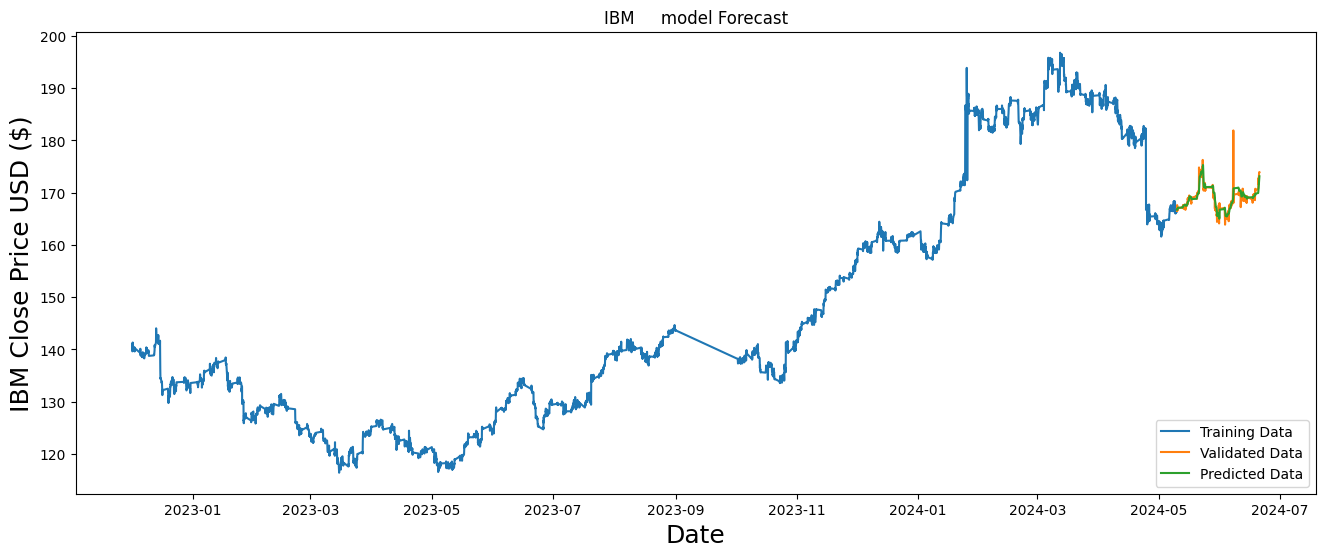

In [261]:
def plot_predictions(stock, data, training_data_len, predictions):
    # Tách dữ liệu huấn luyện và dữ liệu kiểm tra
    train = data[:training_data_len].copy()
    valid = data[training_data_len:].copy()
    
    # Gán cột 'Predictions' cho DataFrame valid
    valid['Predictions'] = predictions
    
    # Vẽ biểu đồ
    plt.figure(figsize=(16, 6))
    title = f'{stock}     model Forecast'
    ylabel = f'{stock} Close Price USD ($)'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['close'], label='Training Data')
    plt.plot(valid['close'], label='Validated Data')
    plt.plot(valid['Predictions'], label='Predicted Data')
    plt.legend(loc='lower right')
    plt.show()
    
    return valid

#Test the function
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [262]:
# Show the valid and predicted prices
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.737656
2024-05-10 07:00:00,166.770,166.715652
2024-05-10 08:00:00,166.510,166.713409
2024-05-10 09:00:00,167.620,166.714188
2024-05-10 10:00:00,167.046,166.764297
...,...,...
2024-06-20 15:00:00,173.900,172.222900
2024-06-20 16:00:00,173.900,172.466827
2024-06-20 17:00:00,173.900,172.705856


In [263]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')


MSE: 1.0847059324831971
Test RMSE: 1.041
R-squared: 0.8395083142809727


In [264]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

def build_improved_RNN_model(x_train, y_train):
    model = Sequential()
    model.add(SimpleRNN(units=64, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.3))
    
    model.add(SimpleRNN(units=32, activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(SimpleRNN(units=16, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))
    
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(x_train, y_train, epochs=50, batch_size=128, validation_split=0.2)
    
    return model

# Test the function
improved_rnn_model = build_improved_RNN_model(x_train, y_train)


Epoch 1/50


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.1178 - val_loss: 0.0815
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0226 - val_loss: 0.0198
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0146 - val_loss: 0.0286
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0149 - val_loss: 0.0286
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0148 - val_loss: 0.0226
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0107 - val_loss: 0.0285
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0110 - val_loss: 0.0270
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0098 - val_loss: 0.0321
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0087 - val_loss: 0.0180
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0080 - val_loss: 0.0275
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0078 - val_loss: 0.0102
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0060 - val_l

In [265]:
TEST_DATA_LENGTH = 100
x_test,y_test, predictions = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


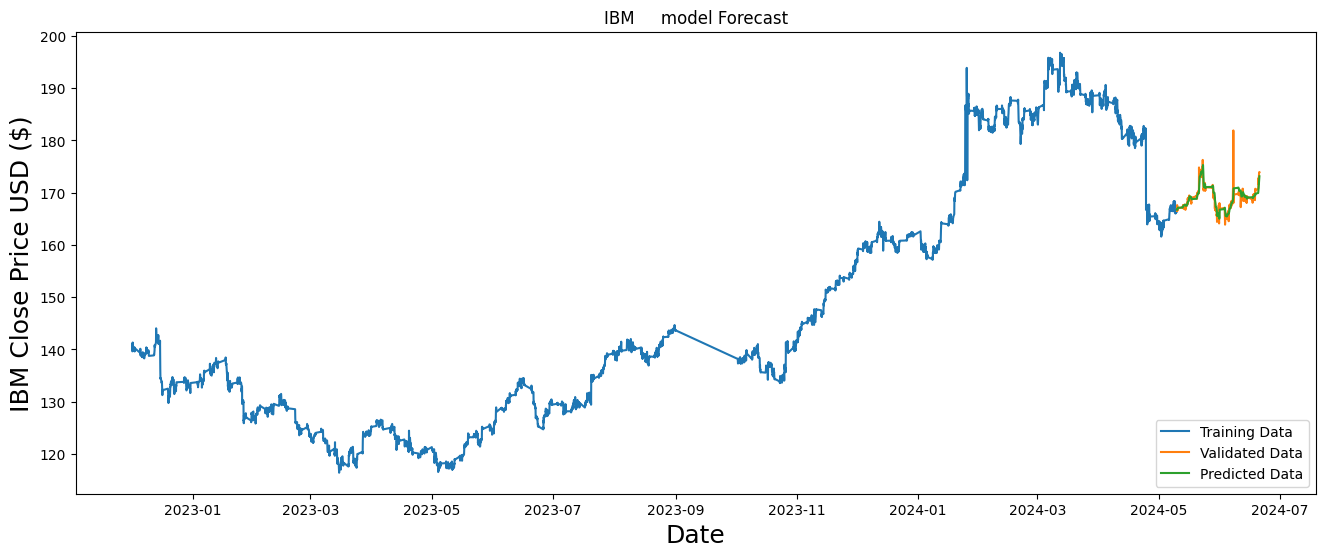

In [266]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [267]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.737656
2024-05-10 07:00:00,166.770,166.715652
2024-05-10 08:00:00,166.510,166.713409
2024-05-10 09:00:00,167.620,166.714188
2024-05-10 10:00:00,167.046,166.764297
...,...,...
2024-06-20 15:00:00,173.900,172.222900
2024-06-20 16:00:00,173.900,172.466827
2024-06-20 17:00:00,173.900,172.705856


In [268]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')

MSE: 1.0847059324831971
Test RMSE: 1.041
R-squared: 0.8395083142809727


In [269]:
def build_lstm_model_3(x_train,y_train):
    # Build the LSTM model
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dense(50, activation='sigmoid'))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        # Train the model
        model.fit(x_train, y_train, batch_size=256, epochs=10)
        return model 

#Test the function
lstm_model_3 = build_lstm_model_3(x_train,y_train)

Epoch 1/10


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 0.4889
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - loss: 0.0177
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - loss: 0.0023
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - loss: 9.2755e-04
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - loss: 5.2363e-04
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 266ms/step - loss: 4.3011e-04
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 3.8966e-04
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - loss: 3.9528e-04
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - loss: 3.9872e-04
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - loss: 3.8845e-04


In [270]:
TEST_DATA_LENGTH = 100
x_test,y_test, predictions = create_testing_data_set(lstm_model,scaler,training_data_len, TEST_DATA_LENGTH)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


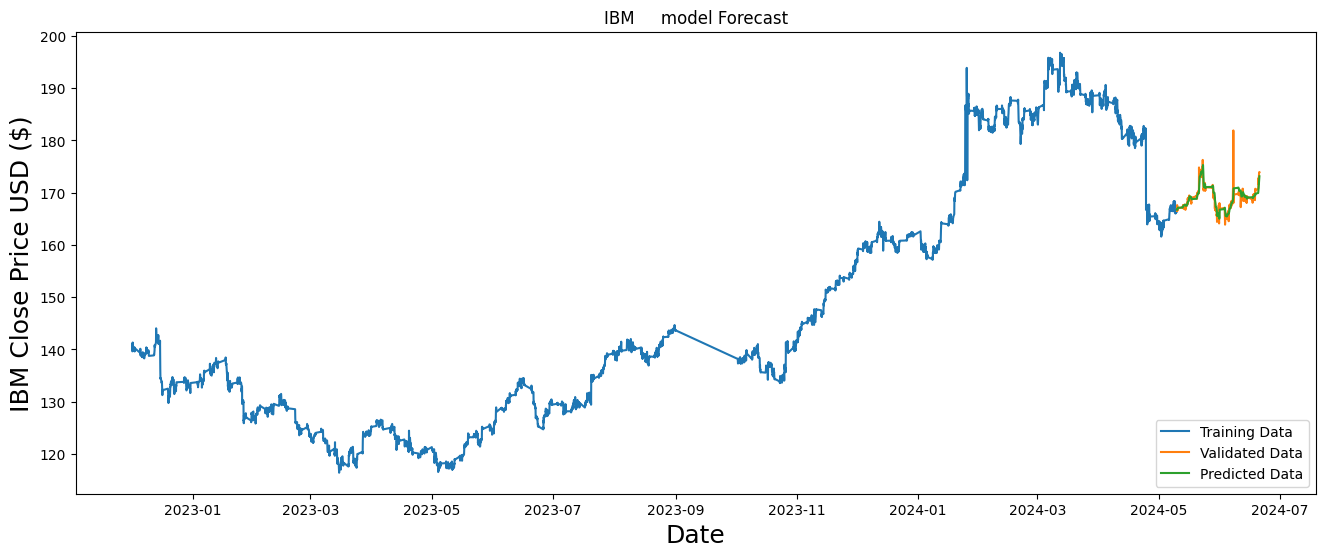

In [271]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [272]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.737656
2024-05-10 07:00:00,166.770,166.715652
2024-05-10 08:00:00,166.510,166.713409
2024-05-10 09:00:00,167.620,166.714188
2024-05-10 10:00:00,167.046,166.764297
...,...,...
2024-06-20 15:00:00,173.900,172.222900
2024-06-20 16:00:00,173.900,172.466827
2024-06-20 17:00:00,173.900,172.705856


In [273]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')

MSE: 1.0847059324831971
Test RMSE: 1.041
R-squared: 0.8395083142809727


In [274]:
# --- mô hình RNN ---
def build_RNN_model(x_train, y_train):
    
    model = Sequential()
    # Thêm lớp ẩn đầu tiên
    model.add(SimpleRNN(units = 10,activation='tanh', return_sequences = True, input_shape = (x_train.shape[1], 1)))
    model.add(Dropout(0.2))  
    # Thêm lớp ẩn thứ 2
    model.add(SimpleRNN(units = 10,activation='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    # Thêm lớp ẩn thứ 3
    model.add(SimpleRNN(units = 10,activation='tanh', return_sequences = True))
    model.add(Dropout(0.2))
    # Thêm lớp ẩn thứ 4
    model.add(SimpleRNN(units = 10))
    model.add(Dropout(0.2))
    # thêm lớp đầu ra
    model.add(Dense(units = 1))
    # Biên dịch mô hình RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # Fit mô hình RNN  với tập dữ liệu Train
    model.fit(x_train, y_train, epochs = 100, batch_size = 256)
    return model
    
rnn_model = build_RNN_model(x_train, y_train)

Epoch 1/100


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.4243
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2294
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1489
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1128
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0913
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0641
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0569
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0496
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0391
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0374
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0342
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0291
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0277
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0248
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0256
E

In [275]:
#Test the function
TEST_DATA_LENGTH = 100
x_test,y_test, predictions = create_testing_data_set(rnn_model,scaler,training_data_len, TEST_DATA_LENGTH)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


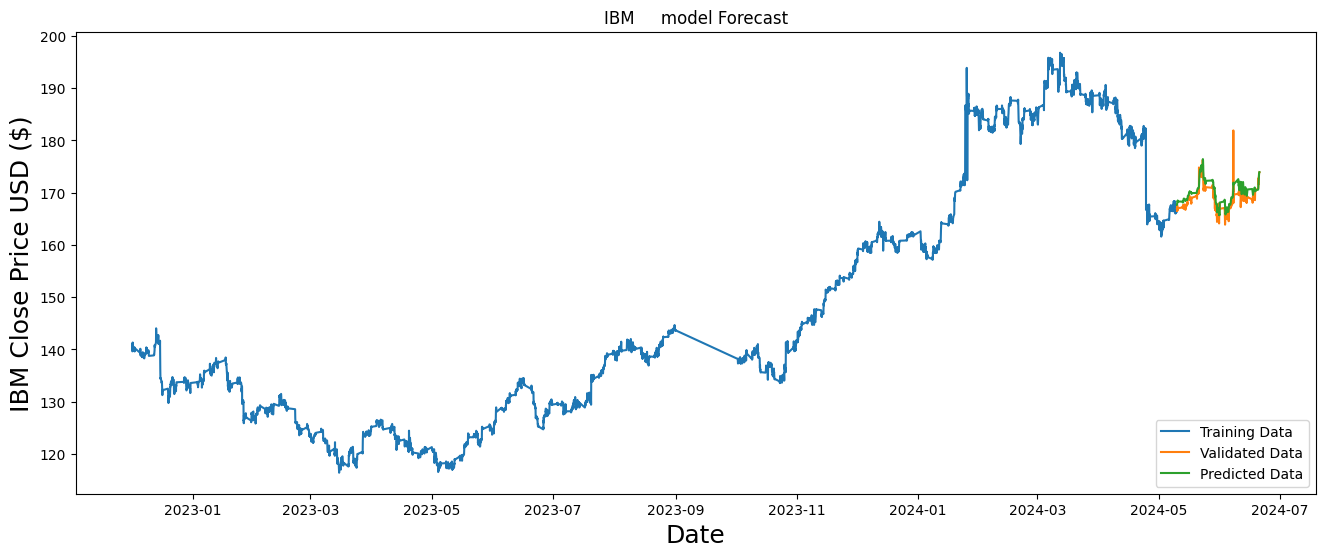

In [276]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [277]:
# Show the valid and predicted prices
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,167.675980
2024-05-10 07:00:00,166.770,167.680359
2024-05-10 08:00:00,166.510,167.735703
2024-05-10 09:00:00,167.620,167.818527
2024-05-10 10:00:00,167.046,168.069321
...,...,...
2024-06-20 15:00:00,173.900,173.680664
2024-06-20 16:00:00,173.900,173.759140
2024-06-20 17:00:00,173.900,173.806152


In [278]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')


MSE: 2.4621645449936014
Test RMSE: 1.569
R-squared: 0.6357013209663016


In [279]:
# --- mô hình GRU ---
def build_GRU_model(x_train, y_train):
        model = Sequential()
        model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(GRU(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Huấn luyện mô hình
        model.fit(x_train, y_train, epochs=10, batch_size=128)     
        return model
    
GRU_model = build_GRU_model(x_train, y_train)

Epoch 1/10


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0747
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 5.6018e-04
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 1.3560e-04
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 1.2332e-04
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 1.2007e-04
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 1.0176e-04
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 8.5672e-05
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 1.0261e-04
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 7.9440e-05
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 9.0952e-05


In [280]:
#Test the function
TEST_DATA_LENGTH = 100
x_test,y_test, predictions = create_testing_data_set(GRU_model,scaler,training_data_len, TEST_DATA_LENGTH)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


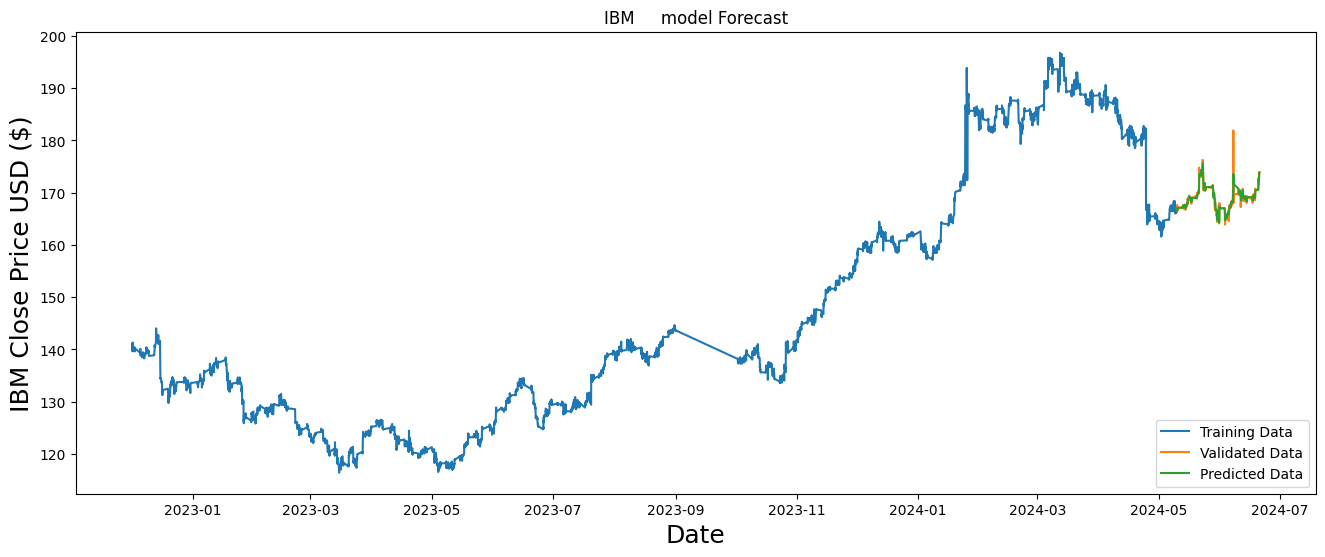

In [281]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [282]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.457809
2024-05-10 07:00:00,166.770,166.599213
2024-05-10 08:00:00,166.510,166.699554
2024-05-10 09:00:00,167.620,166.689728
2024-05-10 10:00:00,167.046,166.956131
...,...,...
2024-06-20 15:00:00,173.900,173.102631
2024-06-20 16:00:00,173.900,173.434479
2024-06-20 17:00:00,173.900,173.654800


In [283]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')


MSE: 0.6608944156152661
Test RMSE: 0.813
R-squared: 0.9022149177320661


In [284]:
x_train.shape

(4967, 60, 1)

In [285]:
def build_lmst2_model(x_train,y_train):
        model=Sequential()
        model.add(LSTM(20,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(LSTM(15,return_sequences=True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(LSTM(15))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1))
    
        adam = optimizers.Adam(0.01)
        model.compile(loss='mean_squared_error',optimizer=adam)
        model.fit(x_train, y_train, epochs=50, batch_size=256)
        return model
lmst2_model =  build_lmst2_model(x_train, y_train)

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.2082
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0145
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0099
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0076
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0069
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0047
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0040
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - loss: 0.0031
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0030
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0029
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0025
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0028
Epoch 13/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0025
Epoch 14/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0021
Epoch 15/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.

In [286]:
#Test the function
TEST_DATA_LENGTH = 100
x_test,y_test, predictions = create_testing_data_set(lmst2_model,scaler,training_data_len, TEST_DATA_LENGTH)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


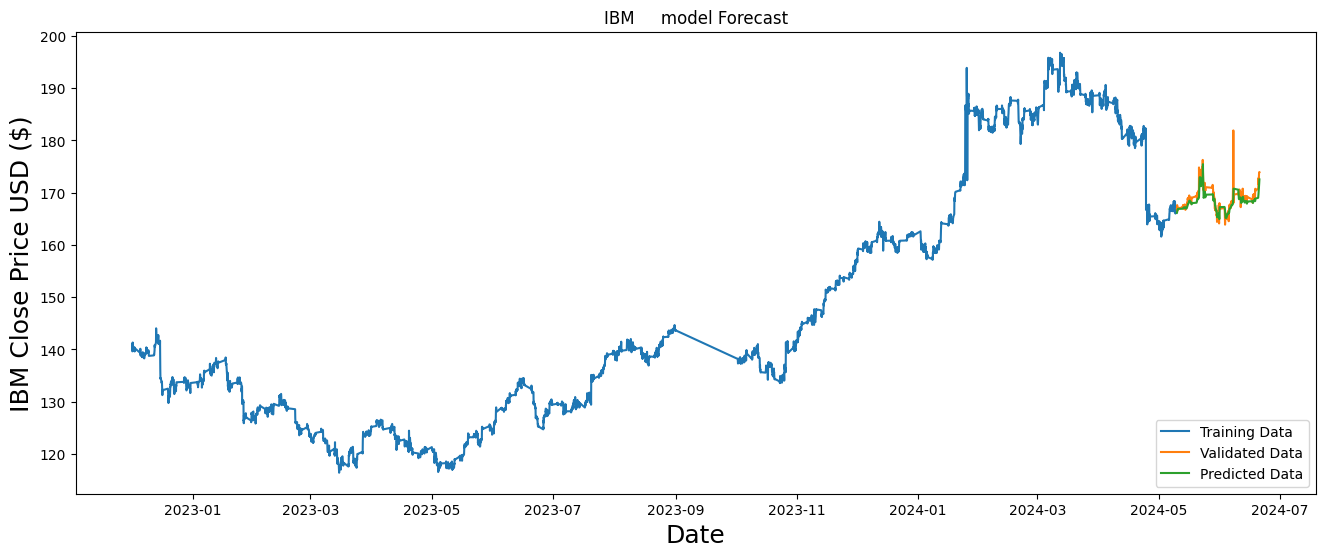

In [287]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [288]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.142944
2024-05-10 07:00:00,166.770,166.178635
2024-05-10 08:00:00,166.510,166.240524
2024-05-10 09:00:00,167.620,166.305115
2024-05-10 10:00:00,167.046,166.413712
...,...,...
2024-06-20 15:00:00,173.900,171.402969
2024-06-20 16:00:00,173.900,171.703186
2024-06-20 17:00:00,173.900,172.012161


In [289]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')


MSE: 1.7623449942058944
Test RMSE: 1.328
R-squared: 0.739245715849374


In [295]:
from sklearn.ensemble import RandomForestRegressor

def build_randomforest_model(x_train, y_train):  
    # Chuyển đổi x_train từ 3D sang 2D
    x_train_2d = x_train.reshape((x_train.shape[0], -1))
    
    # Khởi tạo mô hình với các tham số tùy chọn
    model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    
    # Huấn luyện mô hình
    model.fit(x_train_2d, y_train)
    
    return model

# Gọi hàm để xây dựng và huấn luyện mô hình
RDFR_model = build_randomforest_model(x_train, y_train)


In [296]:
def create_testing_data_set_1(model, scaler, training_data_len, test_data_len):
    # Create the testing data set
    # Create a new array containing scaled values from index training_data_len - test_data_len to the end
    test_data = scaled_data[training_data_len - test_data_len:, :]
    
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i-test_data_len:i, 0])
    
    # Convert the data to a numpy array
    x_test = np.array(x_test)
    
    # Reshape x_test from 3D to 2D
    x_test_2d = x_test.reshape((x_test.shape[0], -1))

    # Get the models predicted price values 
    predictions = model.predict(x_test_2d)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

    return x_test, y_test, predictions

# Test the function
TEST_DATA_LENGTH = 60
x_test, y_test, predictions = create_testing_data_set_1(RDFR_model, scaler, training_data_len, TEST_DATA_LENGTH)


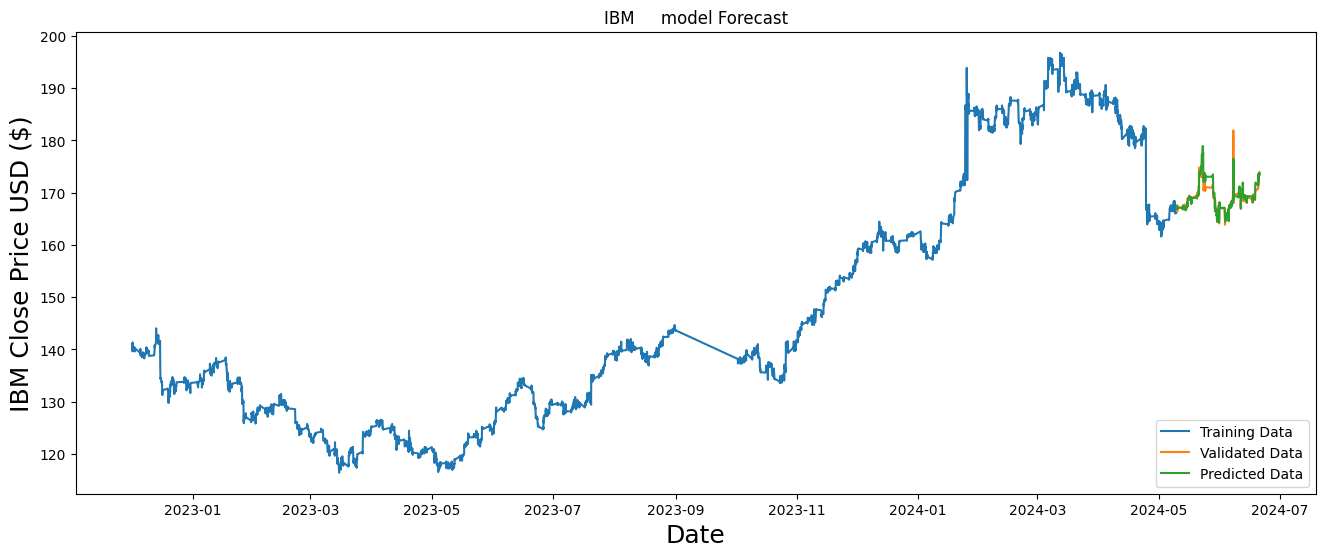

In [297]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [298]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.850522
2024-05-10 07:00:00,166.770,167.052881
2024-05-10 08:00:00,166.510,167.191766
2024-05-10 09:00:00,167.620,167.145276
2024-05-10 10:00:00,167.046,167.459744
...,...,...
2024-06-20 15:00:00,173.900,173.752127
2024-06-20 16:00:00,173.900,173.488415
2024-06-20 17:00:00,173.900,173.547921


In [299]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')

MSE: 1.8127872558877436
Test RMSE: 1.346
R-squared: 0.7317823441037552


In [300]:
from sklearn.ensemble import GradientBoostingRegressor

def build_Gradien_model(x_train, y_train):  
    # Chuyển đổi x_train từ 3D sang 2D
    x_train_2d = x_train.reshape((x_train.shape[0], -1))
    
    # Khởi tạo mô hình với các tham số tùy chọn
    model = GradientBoostingRegressor(n_estimators=100,learning_rate=0.1, max_depth=10, random_state=42)
    
    # Huấn luyện mô hình
    model.fit(x_train_2d, y_train)
    return model

# Gọi hàm để xây dựng và huấn luyện mô hình
Gradien_model = build_Gradien_model(x_train, y_train)


In [301]:
TEST_DATA_LENGTH = 60
x_test, y_test, predictions = create_testing_data_set_1(Gradien_model, scaler, training_data_len, TEST_DATA_LENGTH)

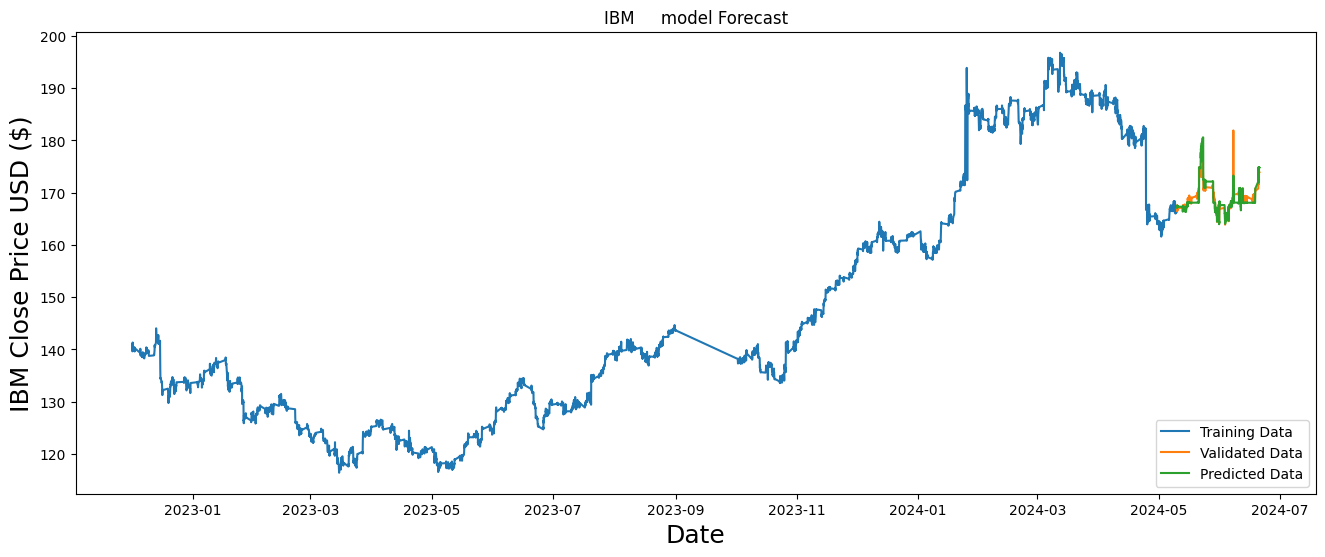

In [302]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [303]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,167.111083
2024-05-10 07:00:00,166.770,167.414468
2024-05-10 08:00:00,166.510,167.346550
2024-05-10 09:00:00,167.620,167.448806
2024-05-10 10:00:00,167.046,167.576233
...,...,...
2024-06-20 15:00:00,173.900,174.864577
2024-06-20 16:00:00,173.900,174.805142
2024-06-20 17:00:00,173.900,174.890634


In [304]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('Test RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')

MSE: 3.483153263996346
Test RMSE: 1.866
R-squared: 0.4846371516778213


In [305]:
from xgboost import XGBRegressor
def build_xgboot_model(x_train,y_train):
    x_train_2d = x_train.reshape((x_train.shape[0], -1))
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(x_train_2d, y_train)
    return model
xgboot_model =build_xgboot_model(x_train, y_train)
    

In [306]:
TEST_DATA_LENGTH = 60
x_test, y_test, predictions = create_testing_data_set_1(xgboot_model, scaler, training_data_len, TEST_DATA_LENGTH)

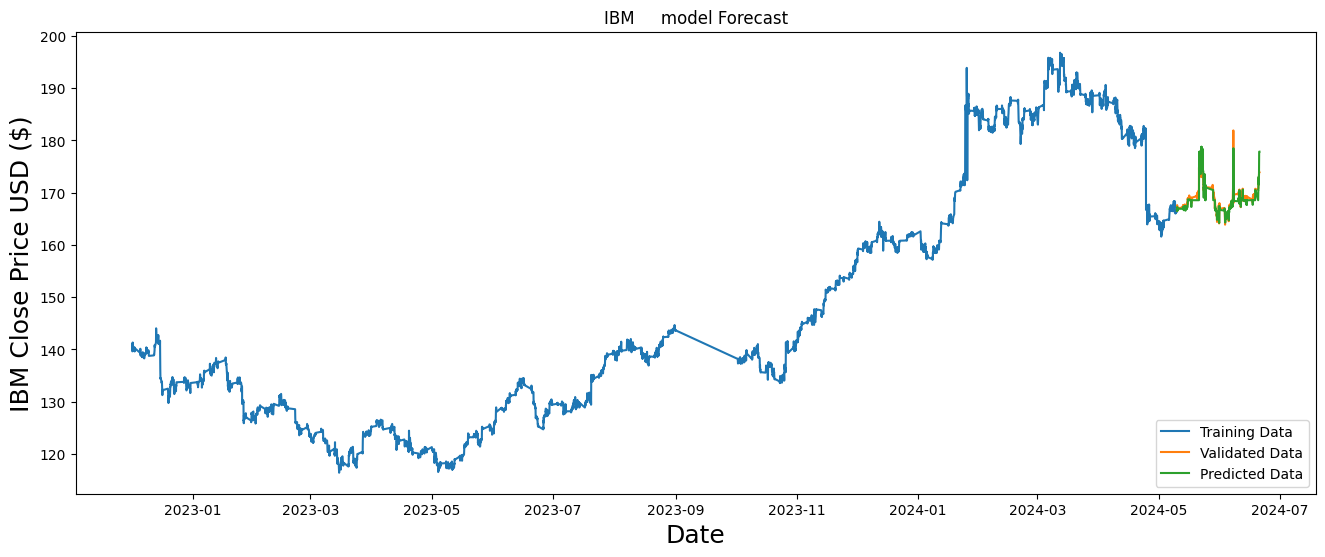

In [307]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [308]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.567871
2024-05-10 07:00:00,166.770,166.554321
2024-05-10 08:00:00,166.510,166.567871
2024-05-10 09:00:00,167.620,166.567871
2024-05-10 10:00:00,167.046,167.246063
...,...,...
2024-06-20 15:00:00,173.900,177.230972
2024-06-20 16:00:00,173.900,177.848267
2024-06-20 17:00:00,173.900,177.848267


In [309]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')

MSE: 2.737367728009499
RMSE: 1.654
R-squared: 0.5949826142322556


In [310]:
from sklearn.ensemble import GradientBoostingRegressor

def build_Gradien_model_2(x_train, y_train):  
    # Chuyển đổi x_train từ 3D sang 2D
    x_train_2d = x_train.reshape((x_train.shape[0], -1))
    
    # Khởi tạo mô hình với các tham số tùy chọn
    model = GradientBoostingRegressor(n_estimators=200,learning_rate=0.05, max_depth=5, random_state=42)
    
    # Huấn luyện mô hình
    model.fit(x_train_2d, y_train)
    return model

# Gọi hàm để xây dựng và huấn luyện mô hình
Gradien_model_2 = build_Gradien_model(x_train, y_train)

In [311]:
TEST_DATA_LENGTH = 60
x_test, y_test, predictions = create_testing_data_set_1(xgboot_model, scaler, training_data_len, TEST_DATA_LENGTH)

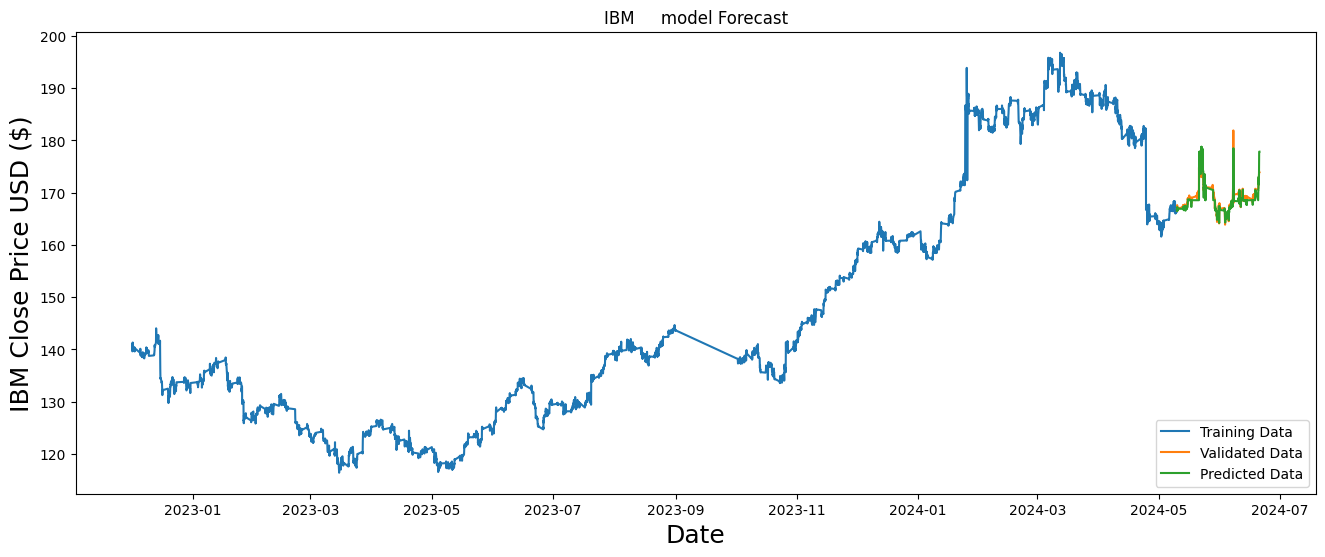

In [312]:
valid = plot_predictions('IBM', data, training_data_len, predictions)

In [313]:
valid

,close,Predictions
timestamp,,
2024-05-10 06:00:00,166.860,166.567871
2024-05-10 07:00:00,166.770,166.554321
2024-05-10 08:00:00,166.510,166.567871
2024-05-10 09:00:00,167.620,166.567871
2024-05-10 10:00:00,167.046,167.246063
...,...,...
2024-06-20 15:00:00,173.900,177.230972
2024-06-20 16:00:00,173.900,177.848267
2024-06-20 17:00:00,173.900,177.848267


In [314]:
mse = mean_squared_error(valid['close'], valid['Predictions'])
rmse = np.sqrt(mse)
r2 = r2_score(valid['close'], valid['Predictions'])
print(f'MSE: {mse}')
print('RMSE: %.3f' % (rmse))
print(f'R-squared: {r2}')

MSE: 2.737367728009499
RMSE: 1.654
R-squared: 0.5949826142322556
